In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Sequential
from keras.models import load_model
from keras.utils.vis_utils import plot_model

from PIL import Image

from sklearn.decomposition import PCA

from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestRegressor

from sklearn.feature_selection import SelectFromModel

from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error

from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

In [2]:
class CONFIG:
    INDEXS = ["R2", "EV", "ME", "MEAN_AE", "MSE", "MEDIAN_AE", "HIT@10", "HIT@100"]
    N_SPLITS = 5

# Load Dataset

In [3]:
header = pd.read_csv("Dataset/header.csv", header=None)
header

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
0,Page Popularity/likes,Page Checkinsâ€™s,Page talking about,Page Category,Derived5,Derived6,Derived7,Derived8,Derived9,Derived10,...,Post published weekday-Friday,Post published weekday-Saturday,Base DateTime weekday-Sunday,Base DateTime weekday-Monday,Base DateTime weekday-Tuesday,Base DateTime weekday-Wednesday,Base DateTime weekday-Thursday,Base DateTime weekday-Friday,Base DateTime weekday-Saturday,Target Variable


In [4]:
training_dataset = pd.read_csv("Dataset/Training/Features_Variant_5.csv",
                               header=None,
                               names=[header.iat[0, i] for i in range(0, 54)])
training_dataset.sample(n=10)

,Page Popularity/likes,Page Checkinsâ€™s,Page talking about,Page Category,Derived5,Derived6,Derived7,Derived8,Derived9,Derived10,...,Post published weekday-Friday,Post published weekday-Saturday,Base DateTime weekday-Sunday,Base DateTime weekday-Monday,Base DateTime weekday-Tuesday,Base DateTime weekday-Wednesday,Base DateTime weekday-Thursday,Base DateTime weekday-Friday,Base DateTime weekday-Saturday,Target Variable
196821,1426027,0,8025,1,0.0,216.0,9.804422,2.0,29.679596,0.0,...,0,0,0,0,0,0,0,0,1,0
191690,5416,24787,314,54,0.0,6.0,0.910448,0.0,1.528157,0.0,...,0,0,0,0,0,0,0,0,1,0
32463,285320,0,5510,24,0.0,275.0,38.960452,16.0,59.993631,0.0,...,0,0,0,0,0,0,0,0,1,0
16703,3002026,0,77240,9,0.0,854.0,70.686555,35.0,102.979855,0.0,...,0,0,0,0,0,0,1,0,0,0
195135,1548753,10803,59597,9,0.0,1479.0,80.830882,41.0,138.300458,0.0,...,0,0,0,0,0,0,0,1,0,0
187522,684014,0,72208,9,0.0,976.0,61.774821,30.0,108.762992,0.0,...,0,0,0,0,0,1,0,0,0,0
151885,2078654,2715,84453,9,0.0,1152.0,161.736056,101.0,183.758354,0.0,...,0,0,0,0,0,1,0,0,0,4
13547,1573,10304,147,32,0.0,21.0,2.540984,0.0,5.152029,0.0,...,0,1,0,0,1,0,0,0,0,0
161993,292911,0,25073,24,0.0,207.0,41.192946,22.0,45.698476,0.0,...,0,0,0,0,0,0,0,1,0,0
96707,513160,0,73487,42,0.0,1457.0,119.841160,33.0,217.646308,0.0,...,0,0,1,0,0,0,0,0,0,2


# Data Preprocessing

In [5]:
post_published_weekday = (training_dataset["Post published weekday-Monday"]
                          + training_dataset["Post published weekday-Tuesday"]
                          + training_dataset["Post published weekday-Wednesday"]
                          + training_dataset["Post published weekday-Thursday"]
                          + training_dataset["Post published weekday-Friday"]).astype("int")
post_published_weekend = (training_dataset["Post published weekday-Sunday"]
                          + training_dataset["Post published weekday-Saturday"]).astype("int")
training_dataset.insert(46, "Post published weekday", post_published_weekday)
training_dataset.insert(47, "Post published weekend", post_published_weekend)
training_dataset.drop(
    ["Post published weekday-Saturday",
     "Post published weekday-Sunday",
     "Post published weekday-Monday",
     "Post published weekday-Tuesday",
     "Post published weekday-Wednesday",
     "Post published weekday-Thursday",
     "Post published weekday-Friday"], axis = 1, inplace = True)
training_dataset

,Page Popularity/likes,Page Checkinsâ€™s,Page talking about,Page Category,Derived5,Derived6,Derived7,Derived8,Derived9,Derived10,...,Post published weekday,Post published weekend,Base DateTime weekday-Sunday,Base DateTime weekday-Monday,Base DateTime weekday-Tuesday,Base DateTime weekday-Wednesday,Base DateTime weekday-Thursday,Base DateTime weekday-Friday,Base DateTime weekday-Saturday,Target Variable
0,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,1,0,0,0,0,0,1,0,0,0
1,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,1,0,1,0,0,0,0,0,0,0
2,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,1,0,0,0,0,0,0,0,1,0
3,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,1,0,0,1,0,0,0,0,0,0
4,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199025,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,1,0,0,0,0,1,0,0,0,203
199026,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,1,0,0,0,0,1,0,0,0,42
199027,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,1,0,0,0,0,1,0,0,0,51
199028,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,1,0,0,0,0,0,1,0,0,17


In [6]:
base_datetime_weekday = (training_dataset["Base DateTime weekday-Monday"]
                          + training_dataset["Base DateTime weekday-Tuesday"]
                          + training_dataset["Base DateTime weekday-Wednesday"]
                          + training_dataset["Base DateTime weekday-Thursday"]
                          + training_dataset["Base DateTime weekday-Friday"]).astype("int")
base_datetime_weekend = (training_dataset["Base DateTime weekday-Sunday"]
                          + training_dataset["Base DateTime weekday-Saturday"]).astype("int")
training_dataset.insert(48, "Base DateTime weekday", base_datetime_weekday)
training_dataset.insert(49, "Base DateTime weekend", base_datetime_weekend)
training_dataset.drop(
    ["Base DateTime weekday-Saturday",
     "Base DateTime weekday-Sunday",
     "Base DateTime weekday-Monday",
     "Base DateTime weekday-Tuesday",
     "Base DateTime weekday-Wednesday",
     "Base DateTime weekday-Thursday",
     "Base DateTime weekday-Friday"], axis = 1, inplace = True)
training_dataset

,Page Popularity/likes,Page Checkinsâ€™s,Page talking about,Page Category,Derived5,Derived6,Derived7,Derived8,Derived9,Derived10,...,Base time,Post length,Post Share Count,Post Promotion Status,H Local,Post published weekday,Post published weekend,Base DateTime weekday,Base DateTime weekend,Target Variable
0,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,25,166,2,0,24,1,0,1,0,0
1,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,70,132,1,0,24,1,0,0,1,0
2,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,26,133,2,0,24,1,0,0,1,0
3,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,67,131,1,0,24,1,0,1,0,0
4,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,65,142,5,0,24,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199025,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,16,77,2123,0,24,1,0,1,0,203
199026,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,4,130,474,0,24,1,0,1,0,42
199027,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,12,12,1511,0,24,1,0,1,0,51
199028,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,31,149,1099,0,24,1,0,1,0,17


In [7]:
features = training_dataset.iloc[:, :43]
features

,Page Popularity/likes,Page Checkinsâ€™s,Page talking about,Page Category,Derived5,Derived6,Derived7,Derived8,Derived9,Derived10,...,CC5,Base time,Post length,Post Share Count,Post Promotion Status,H Local,Post published weekday,Post published weekend,Base DateTime weekday,Base DateTime weekend
0,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,0,25,166,2,0,24,1,0,1,0
1,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,0,70,132,1,0,24,1,0,0,1
2,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,0,26,133,2,0,24,1,0,0,1
3,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,0,67,131,1,0,24,1,0,1,0
4,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,0,65,142,5,0,24,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199025,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,1940,16,77,2123,0,24,1,0,1,0
199026,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,155,4,130,474,0,24,1,0,1,0
199027,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,207,12,12,1511,0,24,1,0,1,0
199028,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,-459,31,149,1099,0,24,1,0,1,0


In [8]:
labels = training_dataset.iloc[:, -1:]
labels

,Target Variable
0,0
1,0
2,0
3,0
4,0
...,...
199025,203
199026,42
199027,51
199028,17


In [9]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=.3, random_state=42)

# Fully Connected Neural Network

## Normalization

In [10]:
def normalize(X_train, X_test, y_train, y_test):
    x_scaler = StandardScaler()
    x_scaler.fit(X_train)
    X_train_norm = x_scaler.transform(X_train)
    X_test_norm = x_scaler.transform(X_test)
    y_scaler = StandardScaler()
    y_scaler.fit(y_train)
    y_train_norm = y_scaler.transform(y_train)
    y_test_norm = y_scaler.transform(y_test)
    return X_train_norm, X_test_norm, y_train_norm, y_test_norm

## Data Preprocessing

### Random Forest

In [11]:
def feature_selection(X_train_norm_df, y_train_norm_df):
    rf_model = RandomForestRegressor(
        max_depth=12,
        min_samples_split=0.0001,
        n_estimators=30,
        random_state=42,
    )
    rf_model.fit(X_train_norm_df, y_train_norm_df.values.ravel())
    
    importances = rf_model.feature_importances_
    indices = np.argsort(importances)
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [X_train_norm_df.columns[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()
    
    sfm = SelectFromModel(rf_model, threshold=0.02, prefit=True)
    selected_feature_ids = sfm.get_support()
    selected_features = X_train_norm_df.columns[selected_feature_ids]
    return selected_features

### PCA

In [12]:
def pca(X_train_norm_df):
    pca = PCA()
    pca.fit(X_train_norm_df)
    X_train_norm_df_reduction = pca.transform(X_train_norm_df)
    
    plt.plot([i for i in range(X_train_norm_df.shape[1])], 
         [np.sum(pca.explained_variance_ratio_[:i]) for i in range(X_train_norm_df.shape[1])])
    plt.show()

## Model Initialization

In [13]:
def create_model(input_shape):
    # Sequential
    model = Sequential()
    model.add(Dense(units=300,
                    activation='relu',
                    input_shape=(input_shape,)))
    model.add(Dropout(0.2))
    model.add(Dense(units=200,
                    activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=100,
                    activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1, activation='linear'))
    model.compile(loss='mse', optimizer='adam')
    print(model.summary())
    return model

## Model Training

In [14]:
def train_model(model, X_train_norm, y_train_norm, X_test_norm, y_test_norm):
    train = model.fit(X_train_norm,
                      y_train_norm,
                      epochs=300,
                      batch_size=1024,
                      verbose=1,
                      validation_data=(X_test_norm, y_test_norm))
    model.save('model_fcnn.h5')
    predict = model.predict(X_test_norm)
    plt.plot(train.history['loss'])  
    plt.plot(train.history['val_loss'])  
    plt.title('Model loss')  
    plt.ylabel('Loss')  
    plt.xlabel('Epoch')  
    plt.legend(['Train', 'Test'], loc='upper left')  
    plt.show()
    plt.figure(figsize=(10, 15))
    plot_model(model, to_file='model_fcnn.png', show_shapes=True)
    img = Image.open('model_fcnn.png', 'r')
    plt.imshow(np.asarray(img))
    plt.show()
    return predict

In [15]:
def plot_test_predict(y_train, y_test_norm, predict, axes=None, k=None):
    y_scaler = StandardScaler()
    y_scaler.fit(y_train)
    test_predict = pd.concat(
        [pd.DataFrame(y_scaler.inverse_transform(y_test_norm)),
         pd.DataFrame(y_scaler.inverse_transform(predict.reshape(-1, 1)))
    ], axis=1)
    headers =  ["Test", "Predict"]
    test_predict.columns = headers
    if axes is not None and k is not None:
        sns.lineplot(data=test_predict, ax=axes[k]).set_title("Test Predict Line Plot k = " + str(k))
    else:
        sns.lineplot(data=test_predict).set_title("Test Predict Line Plot")
    plt.show()
    if axes is not None and k is not None:
        sns.scatterplot(data=test_predict, x="Test", y="Predict", ax=axes[k]).set_title("Test Predict Sctter Plot k = " + str(k))
    else:
        sns.scatterplot(data=test_predict, x="Test", y="Predict").set_title("Test Predict Sctter Plot")
    plt.show()
    x_residual = y_scaler.inverse_transform(predict.reshape(-1, 1))
    y_residual = y_scaler.inverse_transform(y_test_norm) * (y_scaler.inverse_transform(predict.reshape(-1, 1)) - y_scaler.inverse_transform(y_test_norm))
    sns.residplot(x=x_residual, lowess=True, y=y_residual).set_title("Residuals")
    plt.show()
    x_residual = y_scaler.inverse_transform(predict.reshape(-1, 1))
    y_residual = y_scaler.inverse_transform(y_test_norm)
    sns.residplot(x=x_residual, lowess=True, y=y_residual).set_title("Residuals")
    plt.show()

## Model Evaluation

In [16]:
def evaluate(model, y_train, X_test_norm, y_test_norm, predict):
    y_scaler = StandardScaler()
    y_scaler.fit(y_train)
    
    # R-Squared
    r2 = r2_score(y_scaler.inverse_transform(y_test_norm),
                  y_scaler.inverse_transform(predict.reshape(-1, 1)))
    
    # Explained Variance Score
    ev = explained_variance_score(y_scaler.inverse_transform(y_test_norm),
                                  y_scaler.inverse_transform(predict.reshape(-1, 1)))
    
    # Max Error
    me = max_error(y_scaler.inverse_transform(y_test_norm), 
                   y_scaler.inverse_transform(predict.reshape(-1, 1)))
    
    # Mean Absolute Error
    mean_ae = mean_absolute_error(y_scaler.inverse_transform(y_test_norm),
                                  y_scaler.inverse_transform(predict.reshape(-1, 1)))
    
    # Mean Squared Error
    mse = mean_squared_error(y_scaler.inverse_transform(y_test_norm),
                             y_scaler.inverse_transform(predict.reshape(-1, 1)))
    
    # Median Absolute Error
    median_ae = median_absolute_error(y_scaler.inverse_transform(y_test_norm), 
                                      y_scaler.inverse_transform(predict.reshape(-1, 1)))
    
    # Hit@10
    hit = np.abs(
        y_scaler.inverse_transform(y_test_norm).flatten() - 
        y_scaler.inverse_transform(predict.reshape(-1, 1)).flatten()
    ) < 10
    hit_10 = np.sum(hit) / hit.shape[0]
    
    # Hit@100
    y_test_np = y_scaler.inverse_transform(y_test_norm).flatten()
    ordered_y_test = np.argsort(y_test_np)
    max_y_test = ordered_y_test[-100:]
    ordered_predict = np.argsort(y_scaler.inverse_transform(predict.reshape(-1, 1)).flatten())
    max_predict = ordered_predict[-100:]
    acc = 0
    for pred in max_predict:
        if pred in max_y_test:
            acc += 1
    hit_100 = acc / 100
    
    return r2, ev, me, mean_ae, mse, median_ae, hit_10, hit_100

## Final Model

In [17]:
def train_final_model():
    # Normalization
    X_train_norm, X_test_norm, y_train_norm, y_test_norm = normalize(X_train, X_test, y_train, y_test)
    
    # Data Preprocessing
    X_train_norm_df = pd.DataFrame(data=X_train_norm)
    X_test_norm_df = pd.DataFrame(data=X_test_norm)
    y_train_norm_df = pd.DataFrame(data=y_train_norm)
    y_test_norm_df = pd.DataFrame(data=y_test_norm)

    selected_features = feature_selection(X_train_norm_df, y_train_norm_df)
    
    X_train_norm_df = X_train_norm_df[selected_features]
    X_test_norm_df = X_test_norm_df[selected_features]
    
    pca(X_train_norm_df)
    
    X_train_norm = X_train_norm_df.to_numpy()
    X_test_norm = X_test_norm_df.to_numpy()
    y_train_norm = y_train_norm_df.to_numpy()
    y_test_norm = y_test_norm_df.to_numpy()

    # Model Initialization
    model = create_model(X_train_norm_df.shape[1])

    # Model Training
    predict = train_model(model, X_train_norm, y_train_norm, X_test_norm, y_test_norm)
    plot_test_predict(y_train, y_test_norm, predict)

    # Model Evaluation
    r2, ev, me, mean_ae, mse, median_ae, hit_10, hit_100 = evaluate(model, y_train, X_test_norm, y_test_norm, predict)

    results = pd.DataFrame({
        "Index": CONFIG.INDEXS, 
        "Mean": [r2, ev, me, mean_ae, mse, median_ae, hit_10, hit_100]
    })
    print(results)

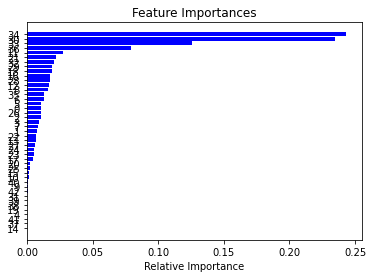

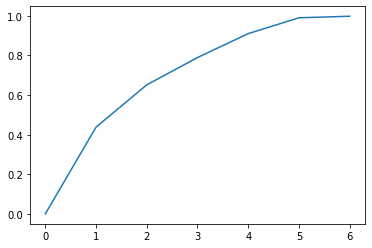

2021-11-01 23:26:43.719395: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-01 23:26:43.901111: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 300)               2400      
_________________________________________________________________
dropout (Dropout)            (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               60200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1

Epoch 69/300
137/137 [==============================] - 1s 7ms/step - loss: 0.3390 - val_loss: 0.2769
Epoch 70/300
137/137 [==============================] - 1s 8ms/step - loss: 0.3396 - val_loss: 0.2810
Epoch 71/300
137/137 [==============================] - 1s 8ms/step - loss: 0.3412 - val_loss: 0.2737
Epoch 72/300
137/137 [==============================] - 1s 7ms/step - loss: 0.3301 - val_loss: 0.2646
Epoch 73/300
137/137 [==============================] - 1s 8ms/step - loss: 0.3308 - val_loss: 0.2798
Epoch 74/300
137/137 [==============================] - 1s 7ms/step - loss: 0.3464 - val_loss: 0.3247
Epoch 75/300
137/137 [==============================] - 1s 7ms/step - loss: 0.3460 - val_loss: 0.2669
Epoch 76/300
137/137 [==============================] - 1s 8ms/step - loss: 0.3328 - val_loss: 0.2836
Epoch 77/300
137/137 [==============================] - 1s 7ms/step - loss: 0.3359 - val_loss: 0.2666
Epoch 78/300
137/137 [==============================] - 1s 8ms/step - loss: 0.3200

Epoch 149/300
137/137 [==============================] - 1s 6ms/step - loss: 0.3114 - val_loss: 0.2699
Epoch 150/300
137/137 [==============================] - 1s 7ms/step - loss: 0.2993 - val_loss: 0.2873
Epoch 151/300
137/137 [==============================] - 1s 7ms/step - loss: 0.3140 - val_loss: 0.2679
Epoch 152/300
137/137 [==============================] - 1s 7ms/step - loss: 0.3058 - val_loss: 0.2797
Epoch 153/300
137/137 [==============================] - 1s 7ms/step - loss: 0.3093 - val_loss: 0.3146
Epoch 154/300
137/137 [==============================] - 1s 7ms/step - loss: 0.3618 - val_loss: 0.2712
Epoch 155/300
137/137 [==============================] - 1s 7ms/step - loss: 0.3074 - val_loss: 0.2807
Epoch 156/300
137/137 [==============================] - 1s 7ms/step - loss: 0.3095 - val_loss: 0.2827
Epoch 157/300
137/137 [==============================] - 1s 7ms/step - loss: 0.3308 - val_loss: 0.2758
Epoch 158/300
137/137 [==============================] - 1s 7ms/step - lo

137/137 [==============================] - 1s 8ms/step - loss: 0.2903 - val_loss: 0.2769
Epoch 229/300
137/137 [==============================] - 1s 8ms/step - loss: 0.2809 - val_loss: 0.2895
Epoch 230/300
137/137 [==============================] - 1s 7ms/step - loss: 0.2895 - val_loss: 0.2861
Epoch 231/300
137/137 [==============================] - 1s 7ms/step - loss: 0.3032 - val_loss: 0.2730
Epoch 232/300
137/137 [==============================] - 1s 7ms/step - loss: 0.2899 - val_loss: 0.2671
Epoch 233/300
137/137 [==============================] - 1s 7ms/step - loss: 0.2829 - val_loss: 0.2870
Epoch 234/300
137/137 [==============================] - 1s 7ms/step - loss: 0.2873 - val_loss: 0.2685
Epoch 235/300
137/137 [==============================] - 1s 8ms/step - loss: 0.2830 - val_loss: 0.2706
Epoch 236/300
137/137 [==============================] - 1s 8ms/step - loss: 0.2829 - val_loss: 0.2686
Epoch 237/300
137/137 [==============================] - 1s 7ms/step - loss: 0.2888 - v

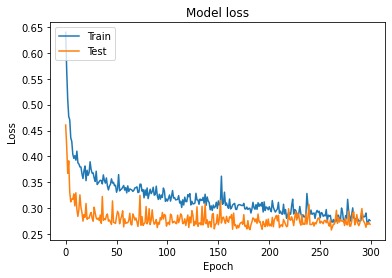

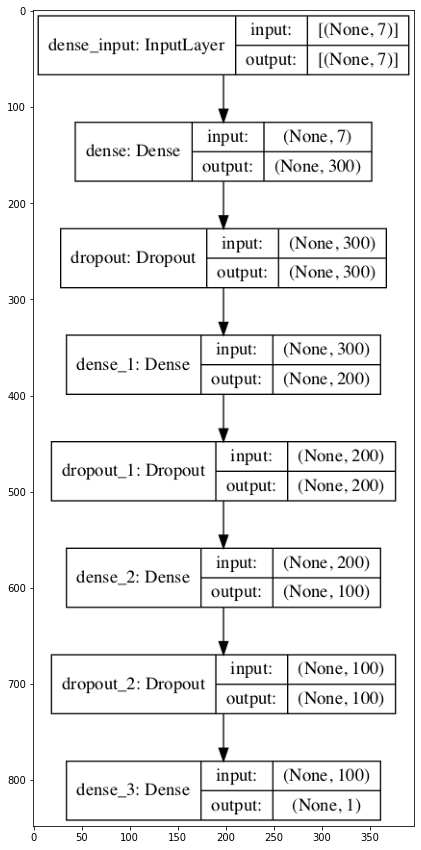

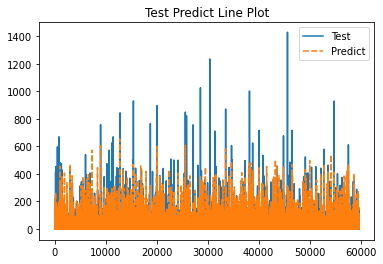

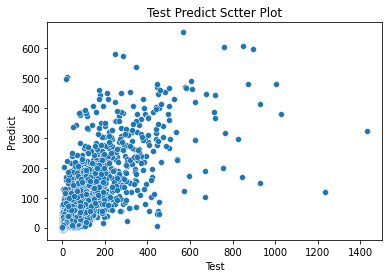

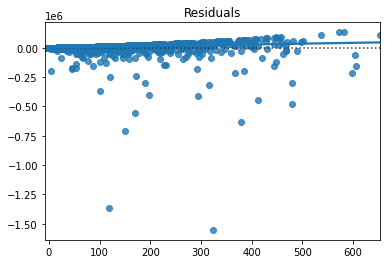

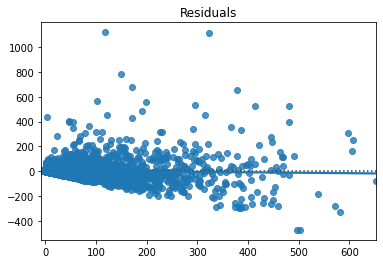

       Index         Mean
0         R2     0.675197
1         EV     0.675213
2         ME  1116.420311
3    MEAN_AE     3.775706
4        MSE   333.286980
5  MEDIAN_AE     0.637099
6     HIT@10     0.932606
7    HIT@100     0.480000


In [18]:
train_final_model()